# Conditional GANs

(adapted from a set of excellent Pytorch GAN tutorials [here](https://github.com/Yangyangii/GAN-Tutorial/blob/master/MNIST/Conditional-GAN.ipynb))

Generative models such as GANs have proven very effective in synthesizing new data examples that resemble a given dataset. The high level idea is to train a generative neural network which, when fed a random noise vector, produces photo-realistic data. 

Often, however, one would like additional *control* over what is generated. For example, if we are trying to synthesize images of dogs, perhaps we don't merely want any dog image but seek an image of a *labrador* with *black* fur which is approximately *5* years old. The tags `labrador, black, 5` are now *auxiliary input variables* which could be fed to the neural network (in addition to the random noise), and changing the auxiliary variables gives us a degree of control over the output that we did not have before. 

Such approaches are called *conditional* generative models. We will train a simple conditional GAN for MNIST. For mathematical details, see [this paper](https://arxiv.org/pdf/1411.1784.pdf)

# Setup and data preparation

For this demo we will use the usual MNIST digit dataset. Our goal will be to build a GAN model which will, in addition to the random noise, take in the *class label* (in this case, a digit between 0 and 9) as input and produce an image of that particular digit. This label can be fed to the generator network as an auxiliary one-hot encoded input vector.

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

In [2]:
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image

In [3]:
import numpy as np
import datetime
import os, sys

In [4]:
from matplotlib.pyplot import imshow, imsave
%matplotlib inline

In [5]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5],
                                std=[0.5])]
)

In [6]:
mnist = datasets.MNIST(root='../data/', train=True, transform=transform, download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



# Setting up the Conditional GAN model


Let us use dense MLPs for both the generator and the discriminator. 

The conditional GAN model is very similar to regular (vanilla) GANs except that 
* we have an additional one-hot encoded class label as input for the generator *G*.
* the discriminator *D* *also* has the ``true'' one-hot encoded class label as input. Therefore, the discriminator is not only evaluating whether the synthesized image is real or fake, but also checking whether the generated image obeys the correct class label.

In [7]:
MODEL_NAME = 'ConditionalGAN'
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
def to_onehot(x, num_classes=10):
    assert isinstance(x, int) or isinstance(x, (torch.LongTensor, torch.cuda.LongTensor))
    if isinstance(x, int):
        c = torch.zeros(1, num_classes).long()
        c[0][x] = 1
    else:
        x = x.cpu()
        c = torch.LongTensor(x.size(0), num_classes)
        c.zero_()
        c.scatter_(1, x, 1) # dim, index, src value
    return c

This function is used to visualize intermediate outputs of the generator.

In [9]:
def get_sample_image(G, n_noise=100):
    img = np.zeros([280, 280])
    for j in range(10):
        c = torch.zeros([10, 10]).to(DEVICE)
        c[:, j] = 1
        z = torch.randn(10, n_noise).to(DEVICE)
        y_hat = G(z,c).view(10, 28, 28)
        result = y_hat.cpu().data.numpy()
        img[j*28:(j+1)*28] = np.concatenate([x for x in result], axis=-1)
    return img

In [10]:
class Generator(nn.Module):

    def __init__(self, input_size=100, condition_size=10, num_classes=784):
        super(Generator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size+condition_size, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, num_classes),
            nn.Tanh()
        )
        
    def forward(self, x, c):
        x, c = x.view(x.size(0), -1), c.view(c.size(0), -1).float()
        v = torch.cat((x, c), 1) # v: [input, label] concatenated vector
        y_ = self.layer(v)
        y_ = y_.view(x.size(0), 1, 28, 28)
        return y_

In [11]:
class Discriminator(nn.Module):

    def __init__(self, input_size=784, condition_size=10, num_classes=1):
        super(Discriminator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size+condition_size, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, num_classes),
            nn.Sigmoid(),
        )
    
    def forward(self, x, c):        
        x, c = x.view(x.size(0), -1), c.view(c.size(0), -1).float()
        v = torch.cat((x, c), 1) # v: [input, label] concatenated vector
        y_ = self.layer(v)
        return y_

In [12]:
D = Discriminator().to(DEVICE)
G = Generator().to(DEVICE)

In [13]:
batch_size = 64
condition_size = 10

In [14]:
data_loader = DataLoader(dataset=mnist, batch_size=batch_size, shuffle=True, drop_last=True)

# Training

Training is just like in vanilla GANs; we will use the binary cross-entropy loss and optimize both networks using ADAM.

It is common to use two time-scales for the generator and disciminator. We will not need this for this particular simple dataset, but the `n_critic` parameter below controls the ratio of number of discriminator updates vs generator updates.

In [15]:
criterion = nn.BCELoss()
D_opt = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
G_opt = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [16]:
max_epoch = 30 # need more than 100 epochs for training generator
step = 0
n_critic = 1 # for training more k steps about Discriminator
n_noise = 100

In [17]:
D_labels = torch.ones([batch_size, 1]).to(DEVICE) # Discriminator label: real
D_fakes = torch.zeros([batch_size, 1]).to(DEVICE) # Discriminator Label: fake

In [18]:
if not os.path.exists('samples'):
    os.makedirs('samples')

In [19]:
for epoch in range(max_epoch):
    for idx, (images, labels) in enumerate(data_loader):
        # Training Discriminator
        x = images.to(DEVICE)
        y = labels.view(batch_size, 1)
        y = to_onehot(y).to(DEVICE)
        x_outputs = D(x, y)
        D_x_loss = criterion(x_outputs, D_labels)

        z = torch.randn(batch_size, n_noise).to(DEVICE)
        z_outputs = D(G(z, y), y)
        D_z_loss = criterion(z_outputs, D_fakes)
        D_loss = D_x_loss + D_z_loss
        
        D.zero_grad()
        D_loss.backward()
        D_opt.step()
        
        if step % n_critic == 0:
            # Training Generator
            z = torch.randn(batch_size, n_noise).to(DEVICE)
            z_outputs = D(G(z, y), y)
            G_loss = criterion(z_outputs, D_labels)

            G.zero_grad()
            G_loss.backward()
            G_opt.step()
        
        if step % 500 == 0:
            print('Epoch: {}/{}, Step: {}, D Loss: {}, G Loss: {}'.format(epoch, max_epoch, step, D_loss.item(), G_loss.item()))
        
        if step % 1000 == 0:
            G.eval()
            img = get_sample_image(G, n_noise)
            imsave('samples/{}_step{}.jpg'.format(MODEL_NAME, str(step).zfill(3)), img, cmap='gray')
            G.train()
        step += 1

Epoch: 0/30, Step: 0, D Loss: 1.4059816598892212, G Loss: 0.6925524473190308
Epoch: 0/30, Step: 500, D Loss: 1.3213050365447998, G Loss: 0.646992564201355
Epoch: 1/30, Step: 1000, D Loss: 1.135793685913086, G Loss: 1.0166163444519043
Epoch: 1/30, Step: 1500, D Loss: 1.106076717376709, G Loss: 1.3797767162322998
Epoch: 2/30, Step: 2000, D Loss: 1.1528747081756592, G Loss: 1.3591117858886719
Epoch: 2/30, Step: 2500, D Loss: 1.4906251430511475, G Loss: 1.521153450012207
Epoch: 3/30, Step: 3000, D Loss: 1.235087275505066, G Loss: 0.9930574297904968
Epoch: 3/30, Step: 3500, D Loss: 1.1685988903045654, G Loss: 0.9132176041603088
Epoch: 4/30, Step: 4000, D Loss: 1.2393507957458496, G Loss: 0.8504868745803833
Epoch: 4/30, Step: 4500, D Loss: 1.3210766315460205, G Loss: 0.8565250635147095
Epoch: 5/30, Step: 5000, D Loss: 1.3670289516448975, G Loss: 0.5280584096908569
Epoch: 5/30, Step: 5500, D Loss: 1.2562540769577026, G Loss: 0.6324337720870972
Epoch: 6/30, Step: 6000, D Loss: 1.42752504348754

# Testing

Let's see how we do!

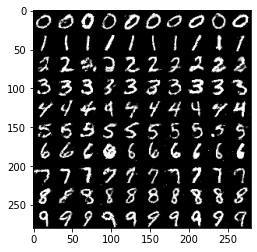

In [20]:
# generation to image
G.eval()
imshow(get_sample_image(G, n_noise), cmap='gray')